強化学習のA2Cを用いた学習を行いたい。シナリオは以下の通り。

V2X上に3つのブロックチェーンを用意する。一つのRSUに対して一つのブロックチェーンが対応する。この時道路を走行中の車両をどれかに所属させたい。この時三つのブロックチェーンの所属車両数はある程度均等になるようにするとともに、RSUに近い車両、RSUに近づいてくる車両は優先的にそのRSUに所属するようにしたい。どのようなA2Cになりますか？今のところデータとしてはRSUの位置、車両の位置、車両の速度は持っている。また車両データを一度に渡し、それを元に配属を決める形にしたい。またRSUに事前に割り当てられている車両はなく、毎回車両群データが渡されてから割り当て車両を全て決定する。

位置データの作成

In [71]:
import json


def make_immu_training_data(log_folder_path):
	extracted_events_file_path = log_folder_path + "extracted_events.json"
	
	with open(extracted_events_file_path, 'r') as f:
		extracted_data = json.load(f)

	# 必要な情報を抽出して辞書にまとめる
	receivable_time_id_data = {}
	for key, value in extracted_data.items():
		geographic_dict = {}
		for vehicle_key, vehicle_value in value["receiver_results"].items():
			if vehicle_value["reception_status"] == "possible":
				geographic_dict[vehicle_key] = vehicle_value["position"]
		
		receivable_time_id_data[value["startTime"]] = geographic_dict



	round_time_id_data = {}
	for key, value in receivable_time_id_data.items():
		round_time_id_data[str(f"{round(float(key), 2):.2f}")] = value


	# order the keys
	round_time_id_data = dict(sorted(round_time_id_data.items(), key=lambda x: float(x[0])))


	extended_time_id_data = {}
	# 元の辞書のキーと値をループして処理
	for key, value in round_time_id_data.items():
		# 新しいキーを追加
		extended_time_id_data[key] = value

		# 小数部を1ずつ増やしながら、指定された範囲のキーが欠けている場合に追加する
		for decimal in range(1,10):
			new_key = f"{round(float(key) + decimal * 0.01, 2):.2f}"
			# 小数点第三位で四捨五入
			if new_key not in round_time_id_data:  # 新しいキーが元の辞書に存在しない場合
				extended_time_id_data[new_key] = value  # 新しいキーを追加し、空のリストを値として設定
			else:
				break

	# write to the json file
	with open( log_folder_path + 'extended_time_geographic_data.json', 'w') as f:
		json.dump(extended_time_id_data, f, indent=4)



# read the json file
max_speed = 80 # km/hour
min_speed = 20
booth_change = True
has_multi_proposer = True
proposer_list = [0,1,2]
validator_num = 250
validator_list = [i for i in range(validator_num  + len(proposer_list)) if i not in proposer_list]


for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/250vehicle/" + str(proposer_id) + "/"
	make_immu_training_data(log_folder_path)



FileNotFoundError: [Errno 2] No such file or directory: './results/speed80_40/250vehicle/0/extracted_events.json'

車両の数変更（評価関数の妥当性を確かめる用）

In [81]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C

class VehicleAssignmentEnv(gym.Env):
    def __init__(self, num_rsus=3, max_vehicles=10):
        super(VehicleAssignmentEnv, self).__init__()
        self.num_rsus = num_rsus
        self.max_vehicles = max_vehicles
        self.current_step = 0  # 現在のステップを追跡
        self.episode_count = 0  # エピソードごとのカウンタ

        # 観測空間を変更（速度情報を削除）
        self.observation_space = spaces.Box(low=0, high=100, shape=(max_vehicles * 2,), dtype=np.float32)
        self.action_space = spaces.MultiDiscrete([num_rsus] * max_vehicles)

        # RSUの位置を固定 (簡単な正三角形配置)
        side_length = 50
        height = np.sqrt(3) / 2 * side_length
        self.rsu_positions = np.array([
            [25, 25],              # 第1のRSUの位置
            [75, 25],              # 第2のRSUの位置
            [50, 50 + height]      # 第3のRSUの位置
        ])


    def reset(self):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 固定半径の設定
        fixed_radius = 25  # 常にこの半径内でランダム配置

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(0, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        num_valid_vehicles = self.max_vehicles  # すべての車両が有効なデータとして扱う
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []
        for i in range(num_valid_vehicles):
            # 各車両をランダムに選択されたRSUの近くに配置
            rsu_pos = self.rsu_positions[i % self.num_rsus]  # 各RSUの周りに均等配置
            random_offset = np.random.uniform(-fixed_radius, fixed_radius, size=2)
            vehicle_position = rsu_pos + random_offset
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定

        # 配列として固定サイズのshapeに変換
        self.vehicle_positions = np.clip(np.array(self.vehicle_positions), 0, 100)  # 座標を0〜100にクリップ
        return self._get_observation()

    def step(self, actions):
        rewards = []
        max_distance = np.linalg.norm([100, 100])  # 距離の最大値（2次元での距離）
        min_distance = 0.01  # 最小値を定義してゼロ割りを防ぐ

        # 距離に基づく報酬
        for idx in range(self.max_vehicles):
            action = actions[idx]
            
            # ダミーデータの場合は報酬をゼロにする
            if np.any(np.all(self.vehicle_positions[idx] == self.rsu_positions, axis=1)):
                rewards.append(0)  # ダミーデータは報酬ゼロ
                continue
            
            distance = np.linalg.norm(self.vehicle_positions[idx] - self.rsu_positions[action])
            raw_distance_reward = max_distance - distance  # 距離が短いほど報酬が大きいようにする
            normalized_distance_reward = 2 * ((raw_distance_reward - min_distance) / (max_distance - min_distance)) - 1
            rewards.append(normalized_distance_reward)

        # 距離報酬の合計
        total_distance_reward = sum(rewards) / self.max_vehicles  # 各車両の平均報酬を取る

        # 負荷バランスを考慮したペナルティの計算（標準偏差を使用）
        rsu_loads = np.bincount(actions, minlength=self.num_rsus)
        load_std_dev = np.std(rsu_loads)  # 負荷の標準偏差を計算
        max_std_dev = self.max_vehicles / self.num_rsus  # 理論的な最大標準偏差（全車両が1つのRSUに集中した場合の近似）

        # 標準偏差を -1 から 1 の範囲に正規化
        normalized_load_penalty = -2 * (load_std_dev / max_std_dev) + 1

        # 総合報酬の計算
        total_reward = 0.5 * total_distance_reward + 0.5 * normalized_load_penalty  # どちらも同じ重要度で加重平均

        self.current_step += 5  # ステップカウンタを増加
        done = self.current_step >= 10
        return self._get_observation(), total_reward, done, {}

    def _get_observation(self):
        # 位置情報のみを返す
        return self.vehicle_positions.flatten()

# 環境の作成
env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=30)

# A2Cエージェントの作成
model = A2C('MlpPolicy', env, learning_rate=0.0003, verbose=1, ent_coef=0.001)

# トレーニング
model.learn(total_timesteps=300000)

# 学習したモデルを保存
# model.save("a2c_vehicle_assignment")

# 学習したモデルを評価
for episode in range(3):
    obs = env.reset()  # 初期状態を取得
    total_reward = 0  # エピソードごとの報酬を初期化
    done = False  # エピソードが終了していないフラグ

    # RSUの位置を出力
    print(f"RSU positions: {env.rsu_positions}")

    for step in range(1):
        action = model.predict(obs)
        obs, reward, done, info = env.step(action[0])  # アクションを取得して環境に渡す
        total_reward += reward  # 報酬を累積

        if done:  # エピソードが終了したら
            print(f"Total reward for the episode: {total_reward}")  # エピソードの合計報酬を表示
            total_reward = 0  # エピソードごとの報酬をリセット
            obs = env.reset()  # 環境をリセット


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 

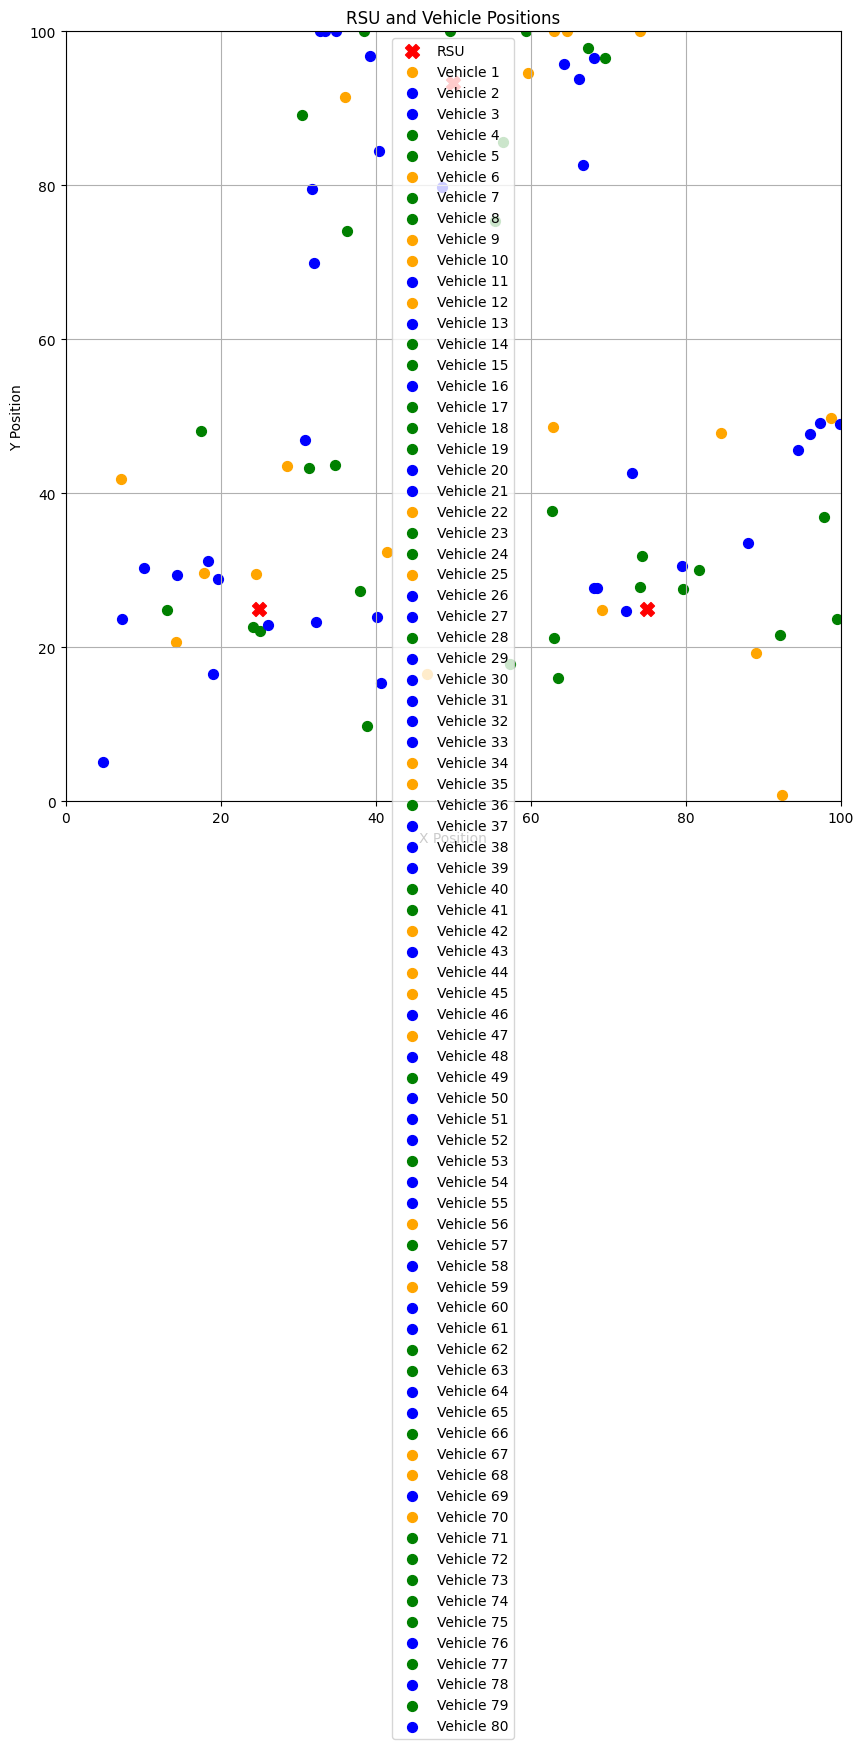

In [82]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments=None):
    plt.figure(figsize=(10, 10))
    plt.xlim(0, 100)
    plt.ylim(0, 100)

    # RSUのプロット
    plt.scatter(rsu_positions[:, 0], rsu_positions[:, 1], c='red', label='RSU', s=100, marker='X')

    # 車両のプロット（ダミーデータを除外）
    for idx, vehicle_pos in enumerate(vehicle_positions):
        # ダミーデータを除外する条件
        if any(np.array_equal(vehicle_pos, rsu) for rsu in rsu_positions):
            continue  # ダミーデータはプロットしない

        # アクションに基づいた色設定
        if assignments is not None:
            color = ['blue', 'green', 'orange'][assignments[idx]]
            plt.scatter(vehicle_pos[0], vehicle_pos[1], c=color, label=f'Vehicle {idx + 1}', s=50)
        else:
            plt.scatter(vehicle_pos[0], vehicle_pos[1], c='blue', label=f'Vehicle {idx + 1}', s=50)

    plt.title('RSU and Vehicle Positions')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid()
    plt.show()

# 環境の初期化
obs = env.reset()

# 学習したモデルを用いてアクションを取得
assignments = model.predict(obs)[0]  # 各車両のアクションを取得
rsu_positions = env.rsu_positions
vehicle_positions = env.vehicle_positions

# プロットを表示
plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments)


車両の数変更（本番）

In [1]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math

class VehicleAssignmentEnv(gym.Env):
    def __init__(self, num_rsus=3, max_vehicles=10):
        super(VehicleAssignmentEnv, self).__init__()
        self.num_rsus = num_rsus
        self.max_vehicles = max_vehicles
        self.min_space = -20
        self.max_space = 1800
        self.current_step = 0  # 現在のステップを追跡
        self.episode_count = 0  # エピソードごとのカウンタ

        # 観測空間を変更（速度情報を削除）
        # self.observation_space = spaces.Box(low=self.min_space, high=self.max_space, shape=(max_vehicles * 2,), dtype=np.float32)

        # RSU の位置情報も観測空間に含めるようにする
        self.observation_space = spaces.Box(
            low=self.min_space, 
            high=self.max_space, 
            shape=(self.max_vehicles * 2,), 
            dtype=np.float32
        )
        self.action_space = spaces.MultiDiscrete([num_rsus] * max_vehicles)

        # RSUの位置を固定 (簡単な正三角形配置)
        self.rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
        ])

    def set_initial_vehicle_positions(self, vehicle_positions):
        """
        車両の初期位置を設定する関数。観測空間内の位置に合わせて正しい形状で入力してください。
        max_vehicles以下の入力であれば、残りをダミーデータとして補完します。
        
        引数:
            vehicle_positions: 車両の位置リスト、shapeは(N, 2)で、範囲は[0, 100]（Nはmax_vehicles以下）
        """
        num_input_vehicles = vehicle_positions.shape[0]
        assert num_input_vehicles <= self.max_vehicles, "入力車両の数はmax_vehicles以下にしてください。"
        
        # ダミーデータを追加して max_vehicles に合わせる
        dummy_vehicle_positions = []
        for i in range(self.max_vehicles - num_input_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]
            dummy_vehicle_positions.append(rsu_pos)  # RSU周りに均等配置

        # 入力された車両位置とダミーデータを結合し、観測空間に合わせてクリップ
        #もしdummy_vehicle_positionsがからの場合、np.vstackでエラーが発生するので、if文で分岐
        if len(dummy_vehicle_positions) == 0:
            all_vehicle_positions = vehicle_positions
        else:
            all_vehicle_positions = np.vstack([vehicle_positions, dummy_vehicle_positions])
        self.vehicle_positions = np.clip(all_vehicle_positions, self.min_space, self.max_space)
        return self._get_observation()
    
    def set_initial_vehicle_positions_random(self):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        num_valid_vehicles = self.max_vehicles
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []
        for i in range(num_valid_vehicles):
            # x 座標は 0 から self.max_space の範囲でランダムに設定
            x_position = np.random.uniform(0, self.max_space)
            # y 座標は 8.4 または 11.6 のどちらかをランダムに選択
            y_position = np.random.choice([8.4, 11.6])
            # 車両の位置として追加
            vehicle_position = [x_position, y_position]
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])

        # 配列として固定サイズのshapeに変換
        self.vehicle_positions = np.clip(np.array(self.vehicle_positions), self.min_space, self.max_space)  # 座標を0〜100にクリップ
        return self._get_observation()

    def reset(self):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        num_valid_vehicles = self.max_vehicles
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []
        for i in range(num_valid_vehicles):
            # x 座標は 0 から self.max_space の範囲でランダムに設定
            x_position = np.random.uniform(0, self.max_space)
            # y 座標は 8.4 または 11.6 のどちらかをランダムに選択
            y_position = np.random.choice([8.4, 11.6])
            # 車両の位置として追加
            vehicle_position = [x_position, y_position]
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])

        # 配列として固定サイズのshapeに変換
        self.vehicle_positions = np.clip(np.array(self.vehicle_positions), self.min_space, self.max_space)  # 座標を0〜100にクリップ
        return self._get_observation()

    def step(self, actions):
        rewards = []
        # max_distance = np.linalg.norm([20, 2000])  # 距離の最大値（2次元での距離）
        # max_distance = np.max([np.linalg.norm(pos - rsu) for pos in self.vehicle_positions for rsu in self.rsu_positions])
        min_distance = 0.01  # 最小値を定義してゼロ割りを防ぐ

        # # 距離に基づく報酬
        # for idx in range(self.max_vehicles):
        #     action = actions[idx]
            
        #     # ダミーデータの場合は報酬をゼロにする
        #     if np.any(np.all(self.vehicle_positions[idx] == self.rsu_positions, axis=1)):
        #         rewards.append(0)  # ダミーデータは報酬ゼロ
        #         continue
            
        #     distance = np.linalg.norm(self.vehicle_positions[idx] - self.rsu_positions[action])
        #     # max_distance = max_distance = np.max([np.linalg.norm(self.vehicle_positions[idx] - rsu) for rsu in self.rsu_positions])
        #     raw_distance_reward = max_distance - distance  # 距離が短いほど報酬が大きいようにする
        #     normalized_distance_reward = 2 * ((raw_distance_reward - min_distance) / (max_distance - min_distance)) - 1
        #     rewards.append(normalized_distance_reward)

        for idx in range(self.max_vehicles):
            action = actions[idx]  # エージェントが選択したRSU

            # ダミーデータの場合は報酬をゼロにする
            if np.any(np.all(self.vehicle_positions[idx] == self.rsu_positions, axis=1)):
                rewards.append(0)  # ダミーデータは報酬ゼロ
                continue

            # すべてのRSUとの距離を計算
            distances = np.array([np.linalg.norm(self.vehicle_positions[idx] - rsu) for rsu in self.rsu_positions])
            
            # 最短距離と最長距離を特定
            min_dist = np.min(distances)
            max_dist = np.max(distances)
            
            # 選択したRSUの距離
            selected_distance = distances[action]
            
            # 報酬の計算
            # 報酬の計算（距離が離れるにつれ2乗で減少し、-1〜1の範囲に正規化）
            normalized_distance = (selected_distance - min_dist) / (max_dist - min_dist)
            reward = 1 - 2 * (normalized_distance)
            
            rewards.append(reward)
            # print(f"Vehicle {idx + 1} to RSU {action + 1}: {reward}")

        # 距離報酬の合計
        actual_rewards = [reward for reward in rewards if reward != 0]  # ダミーデータの報酬を除外
        total_distance_reward = sum(actual_rewards) / len(actual_rewards) if actual_rewards else 0


        # 負荷バランスを考慮したペナルティの計算（標準偏差を使用）
        rsu_loads = np.bincount(actions, minlength=self.num_rsus)
        load_std_dev = np.std(rsu_loads)  # 負荷の標準偏差を計算
        max_std_dev = self.max_vehicles / self.num_rsus  # 理論的な最大標準偏差（全車両が1つのRSUに集中した場合の近似）
        
        # 標準偏差を -1 から 1 の範囲に正規化
        # normalized_load_penalty = -2 * (load_std_dev / max_std_dev) + 1
        max_log_std_dev = 10
        log_load_std_dev = min(-1 * math.log(load_std_dev / max_std_dev), max_log_std_dev)
        normalized_load_penalty = 2 * log_load_std_dev / max_log_std_dev - 1




        # 総合報酬の計算
        total_reward = 0.8 * total_distance_reward + 0.2 * normalized_load_penalty  # どちらも同じ重要度で加重平均

        # print(f"Total distance reward: {total_distance_reward}, Load penalty: {normalized_load_penalty}")
        # print(f"Total reward: {total_reward}")

        self.current_step += 1  # ステップカウンタを増加
        done = self.current_step >= 1
        return self._get_observation(), total_reward, done, {}

    def _get_observation(self):
        # 位置情報のみを返す
        # 車両の位置情報をフラットにしたものと、RSU の位置情報を結合する
        return self.vehicle_positions.flatten()
    

# 環境の作成
env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=180)

# A2Cエージェントの作成
model = A2C('MlpPolicy', env, learning_rate=0.0001, verbose=1, ent_coef=0.003)

# トレーニング
model.learn(total_timesteps=20000)

# 学習したモデルを保存
model.save("a2c_vehicle_assignment")

# 学習したモデルを評価
for episode in range(3):
    obs = env.reset()  # 初期状態を取得
    total_reward = 0  # エピソードごとの報酬を初期化
    done = False  # エピソードが終了していないフラグ

    # RSUの位置を出力
    print(f"RSU positions: {env.rsu_positions}")

    for step in range(1):
        action = model.predict(obs)
        obs, reward, done, info = env.step(action[0])  # アクションを取得して環境に渡す
        total_reward += reward  # 報酬を累積

        if done:  # エピソードが終了したら
            print(f"Total reward for the episode: {total_reward}")  # エピソードの合計報酬を表示
            total_reward = 0  # エピソードごとの報酬をリセット
            obs = env.reset()  # 環境をリセット

# # 学習メトリクスをプロット
# metrics_callback.plot_metrics()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/lucvil/.pyenv/versions/3.11.4/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


ValueError: math domain error

[0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 2 0 0 0 0 0 1 2 0 0 0 2 0 0 0 2 0 0 2 0 1
 0 0 0 1 1 2 0 1 0 2 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 2 0 2 0 1 0 0 0 0 0 0 0
 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 2 1 2 1 0 1 2 2 1 2 2 1 1 2
 1 2 2 1 1 2 1 0 2 2 0 1 0 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2 1 2 1 2 2 0 2
 1 2 1 1 2 2 2 0 2 1 2 1 2 2 2 0 1 2 1 2 2 2 2 2 0 2 0 2 1 1 0 2]
[60 58 62]


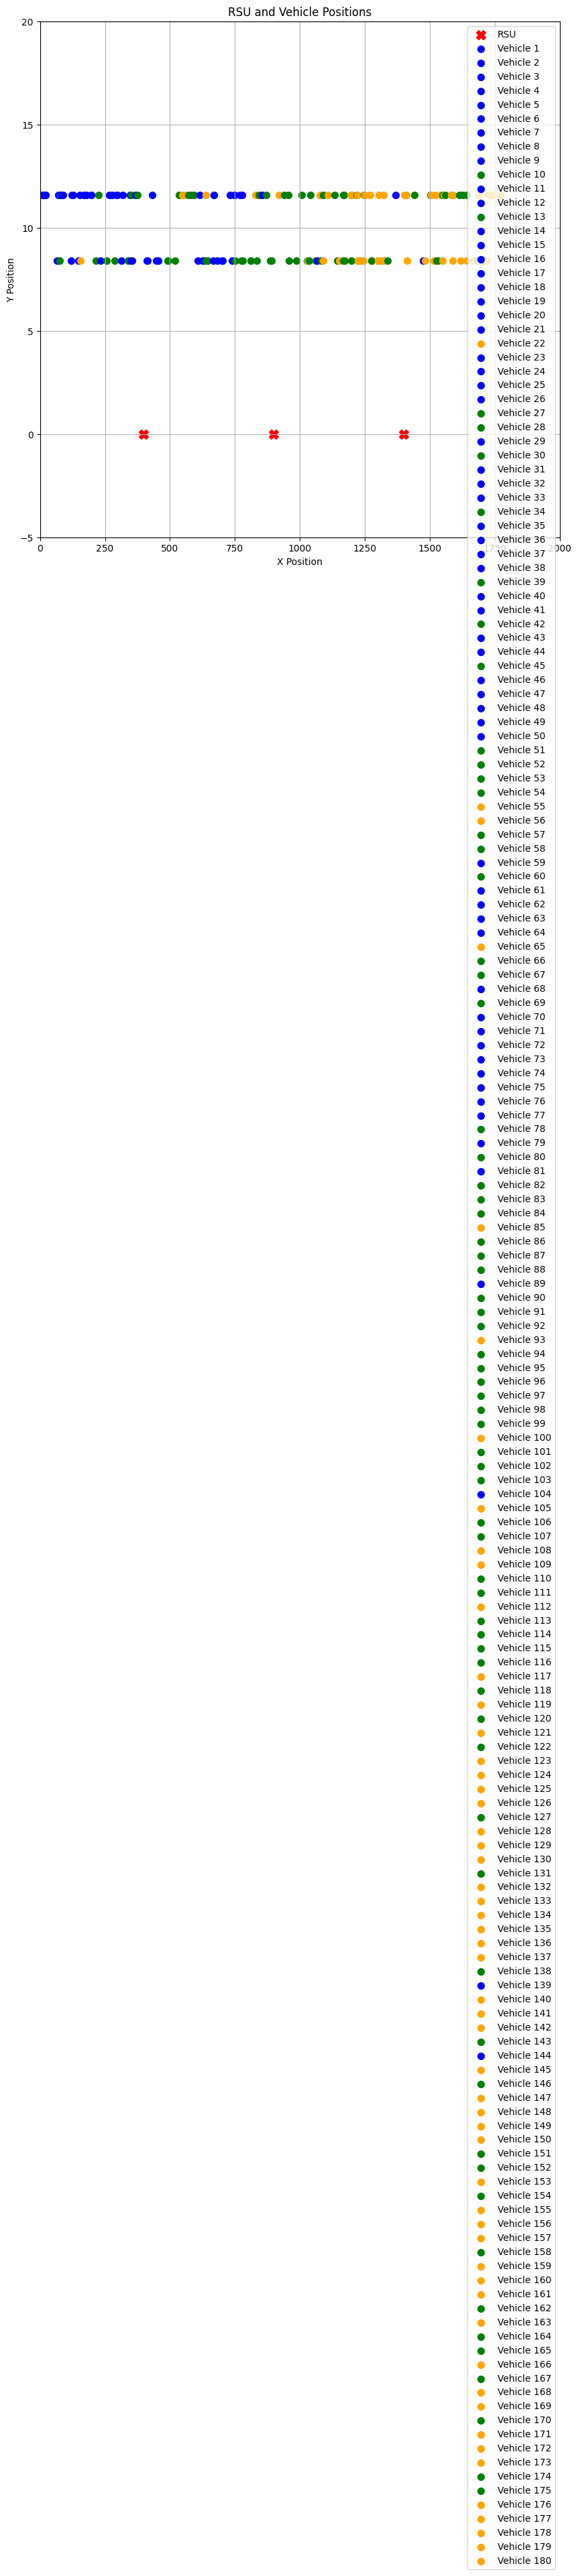

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments=None):
    plt.figure(figsize=(10, 10))
    plt.xlim(0, 2000)
    plt.ylim(-5, 20)

    # RSUのプロット
    plt.scatter(rsu_positions[:, 0], rsu_positions[:, 1], c='red', label='RSU', s=100, marker='X')

    # 車両のプロット（ダミーデータを除外）
    for idx, vehicle_pos in enumerate(vehicle_positions):
        # ダミーデータを除外する条件
        if any(np.array_equal(vehicle_pos, rsu) for rsu in rsu_positions):
            continue  # ダミーデータはプロットしない

        # アクションに基づいた色設定
        if assignments is not None:
            color = ['blue', 'green', 'orange'][assignments[idx]]
            # plt.scatter(vehicle_pos[0], vehicle_pos[1], c=color, label=f'Vehicle {idx + 1}', s=50)
            plt.scatter(vehicle_pos[0], vehicle_pos[1], c=color, s=50)
        else:
            # plt.scatter(vehicle_pos[0], vehicle_pos[1], c='blue', label=f'Vehicle {idx + 1}', s=50)
            plt.scatter(vehicle_pos[0], vehicle_pos[1], c='blue', s=50)

    plt.title('RSU and Vehicle Positions')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid()
    plt.show()

# 環境の初期化
obs = env.reset()
# obs = env.set_initial_vehicle_positions_random()

# 学習したモデルを用いてアクションを取得
assignments = model.predict(obs)[0]  # 各車両のアクションを取得
print(model.predict(obs)[0])
# model.predict(obs)[0]において、0,1,2がそれぞれ何回出てくるかをカウントしてprintする
print(np.bincount(model.predict(obs)[0]))

rsu_positions = env.rsu_positions
vehicle_positions = env.vehicle_positions



# プロットを表示
plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments)


envの再読込

In [3]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class VehicleAssignmentEnv(gym.Env):
    def __init__(self, num_rsus=3, max_vehicles=10):
        super(VehicleAssignmentEnv, self).__init__()
        self.num_rsus = num_rsus
        self.max_vehicles = max_vehicles
        self.min_space = -20
        self.max_space = 1800
        self.current_step = 0  # 現在のステップを追跡
        self.episode_count = 0  # エピソードごとのカウンタ

        # 観測空間を変更（速度情報を削除）
        # self.observation_space = spaces.Box(low=self.min_space, high=self.max_space, shape=(max_vehicles * 2,), dtype=np.float32)

        # RSU の位置情報も観測空間に含めるようにする
        self.observation_space = spaces.Box(
            low=self.min_space, 
            high=self.max_space, 
            shape=(self.max_vehicles * 2,), 
            dtype=np.float32
        )
        self.action_space = spaces.MultiDiscrete([num_rsus] * max_vehicles)

        # RSUの位置を固定 (簡単な正三角形配置)
        self.rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
        ])

    def set_initial_vehicle_positions(self, vehicle_positions):
        """
        車両の初期位置を設定する関数。観測空間内の位置に合わせて正しい形状で入力してください。
        max_vehicles以下の入力であれば、残りをダミーデータとして補完します。
        
        引数:
            vehicle_positions: 車両の位置リスト、shapeは(N, 2)で、範囲は[0, 100]（Nはmax_vehicles以下）
        """
        num_input_vehicles = vehicle_positions.shape[0]
        assert num_input_vehicles <= self.max_vehicles, "入力車両の数はmax_vehicles以下にしてください。"
        
        # ダミーデータを追加して max_vehicles に合わせる
        dummy_vehicle_positions = []
        for i in range(self.max_vehicles - num_input_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]
            dummy_vehicle_positions.append(rsu_pos)  # RSU周りに均等配置

        # 入力された車両位置とダミーデータを結合し、観測空間に合わせてクリップ
        #もしdummy_vehicle_positionsがからの場合、np.vstackでエラーが発生するので、if文で分岐
        if len(dummy_vehicle_positions) == 0:
            all_vehicle_positions = vehicle_positions
        else:
            all_vehicle_positions = np.vstack([vehicle_positions, dummy_vehicle_positions])
        self.vehicle_positions = np.clip(all_vehicle_positions, self.min_space, self.max_space)
        return self._get_observation()
    
    def set_initial_vehicle_positions_random(self):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        num_valid_vehicles = self.max_vehicles
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []
        for i in range(num_valid_vehicles):
            # x 座標は 0 から self.max_space の範囲でランダムに設定
            x_position = np.random.uniform(0, self.max_space)
            # y 座標は 8.4 または 11.6 のどちらかをランダムに選択
            y_position = np.random.choice([8.4, 11.6])
            # 車両の位置として追加
            vehicle_position = [x_position, y_position]
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])

        # 配列として固定サイズのshapeに変換
        self.vehicle_positions = np.clip(np.array(self.vehicle_positions), self.min_space, self.max_space)  # 座標を0〜100にクリップ
        return self._get_observation()

    def reset(self):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        num_valid_vehicles = self.max_vehicles
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []
        for i in range(num_valid_vehicles):
            # x 座標は 0 から self.max_space の範囲でランダムに設定
            x_position = np.random.uniform(0, self.max_space)
            # y 座標は 8.4 または 11.6 のどちらかをランダムに選択
            y_position = np.random.choice([8.4, 11.6])
            # 車両の位置として追加
            vehicle_position = [x_position, y_position]
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])

        # 配列として固定サイズのshapeに変換
        self.vehicle_positions = np.clip(np.array(self.vehicle_positions), self.min_space, self.max_space)  # 座標を0〜100にクリップ
        return self._get_observation()

    def step(self, actions):
        rewards = []
        # max_distance = np.linalg.norm([20, 2000])  # 距離の最大値（2次元での距離）
        # max_distance = np.max([np.linalg.norm(pos - rsu) for pos in self.vehicle_positions for rsu in self.rsu_positions])
        min_distance = 0.01  # 最小値を定義してゼロ割りを防ぐ

        # # 距離に基づく報酬
        # for idx in range(self.max_vehicles):
        #     action = actions[idx]
            
        #     # ダミーデータの場合は報酬をゼロにする
        #     if np.any(np.all(self.vehicle_positions[idx] == self.rsu_positions, axis=1)):
        #         rewards.append(0)  # ダミーデータは報酬ゼロ
        #         continue
            
        #     distance = np.linalg.norm(self.vehicle_positions[idx] - self.rsu_positions[action])
        #     # max_distance = max_distance = np.max([np.linalg.norm(self.vehicle_positions[idx] - rsu) for rsu in self.rsu_positions])
        #     raw_distance_reward = max_distance - distance  # 距離が短いほど報酬が大きいようにする
        #     normalized_distance_reward = 2 * ((raw_distance_reward - min_distance) / (max_distance - min_distance)) - 1
        #     rewards.append(normalized_distance_reward)

        for idx in range(self.max_vehicles):
            action = actions[idx]  # エージェントが選択したRSU

            # ダミーデータの場合は報酬をゼロにする
            if np.any(np.all(self.vehicle_positions[idx] == self.rsu_positions, axis=1)):
                rewards.append(0)  # ダミーデータは報酬ゼロ
                continue

            # すべてのRSUとの距離を計算
            distances = np.array([np.linalg.norm(self.vehicle_positions[idx] - rsu) for rsu in self.rsu_positions])
            
            # 最短距離と最長距離を特定
            min_dist = np.min(distances)
            max_dist = np.max(distances)
            
            # 選択したRSUの距離
            selected_distance = distances[action]
            
            # 報酬の計算
            # 報酬の計算（距離が離れるにつれ2乗で減少し、-1〜1の範囲に正規化）
            normalized_distance = (selected_distance - min_dist) / (max_dist - min_dist)
            reward = 1 - 2 * (normalized_distance)
            
            rewards.append(reward)
            # print(f"Vehicle {idx + 1} to RSU {action + 1}: {reward}")

        # 距離報酬の合計
        actual_rewards = [reward for reward in rewards if reward != 0]  # ダミーデータの報酬を除外
        total_distance_reward = sum(actual_rewards) / len(actual_rewards) if actual_rewards else 0


        # 負荷バランスを考慮したペナルティの計算（標準偏差を使用）
        rsu_loads = np.bincount(actions, minlength=self.num_rsus)
        load_std_dev = np.std(rsu_loads)  # 負荷の標準偏差を計算
        max_std_dev = self.max_vehicles / self.num_rsus  # 理論的な最大標準偏差（全車両が1つのRSUに集中した場合の近似）

        # 標準偏差を -1 から 1 の範囲に正規化
        normalized_load_penalty = -2 * (load_std_dev / max_std_dev) + 1

        # 総合報酬の計算
        total_reward = 0.8 * total_distance_reward + 0.2 * normalized_load_penalty  # どちらも同じ重要度で加重平均

        # print(f"Total distance reward: {total_distance_reward}, Load penalty: {normalized_load_penalty}")
        # print(f"Total reward: {total_reward}")

        self.current_step += 1  # ステップカウンタを増加
        done = self.current_step >= 1
        return self._get_observation(), total_reward, done, {}

    def _get_observation(self):
        # 位置情報のみを返す
        # 車両の位置情報をフラットにしたものと、RSU の位置情報を結合する
        return self.vehicle_positions.flatten()
    


# 環境の作成
env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=180)

IMMUによる車両の分配

In [3]:
import re
import json
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import copy

def immu_vehicle_assignment(communicable_validator_list, validator_geographic_list, model, env):
	rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
    ])
	max_vehicle = 180
	while len(communicable_validator_list) < max_vehicle:
		# len(communicable_validator_list)がmax_vehicleになるまでrsu_positions[len(communicable_validator_list)%3]を追加
		communicable_validator_list.append("-1")
		validator_geographic_list.append(rsu_positions[len(communicable_validator_list)%3])
	
    # `validator_geographic_list`に基づいて`communicable_validator_list`と`validator_geographic_list`を並び替える
	sorted_lists = sorted(zip(communicable_validator_list, validator_geographic_list), key=lambda x: (x[1][0], x[1][1]))
	communicable_validator_list = [v for v, _ in sorted_lists]
	validator_geographic_list = [x for _, x in sorted_lists]

	# print("Sorted Communicable Validator List:", communicable_validator_list)
	# print("Sorted Validator Geographic List:", validator_geographic_list)

	# ここで、各validatorに対して、最も近いproposerを割り当てる
	obs = env.set_initial_vehicle_positions(np.array(validator_geographic_list))
	assignments = model.predict(obs)[0]

	assignments_result_json = []
	assignments_result_json.append([])
	assignments_result_json.append([])
	assignments_result_json.append([])
	for index, validator_id in enumerate(communicable_validator_list):
		if validator_id != "-1":
			assignments_result_json[assignments[index]].append(int(validator_id))

	for assignment in assignments_result_json:
		assignment.sort()
		

	return assignments_result_json
		
	

model_path = "a2c_vehicle_assignment_180_0.7_0.3"
model = A2C.load(model_path)

# read the json file
max_speed = 80 # km/hour
min_speed = 20
proposer_list = [0,1,2]

vehicle_assignment_result_timeline = {}
for proposer_id in proposer_list:
	vehicle_assignment_result_timeline[proposer_id] = {}
geographic_time_json = {}

for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/250vehicle/" + str(proposer_id) + "/"
	# log_foloder_path下のextended_time_geographic_data.jsonを読み込む
	extended_time_geographic_data_path = log_folder_path + "extended_time_geographic_data.json"
	with open(extended_time_geographic_data_path) as f:
		extended_time_geographic_data = json.load(f)
	geographic_time_json[proposer_id] = extended_time_geographic_data

# geographic_time_jsonのそれぞれの中身で共通のkeyを取得
common_keys = set(geographic_time_json[proposer_list[0]].keys())
for proposer_id in proposer_list:
	common_keys = common_keys & set(geographic_time_json[proposer_id].keys())
# listに直してsort
common_keys = list(common_keys)
# 中身を数値に直してソートをした後、strに直す
# strに直すとき絶対に小数点第2位まで表示される文字列にする
common_keys = [str("{:.2f}".format(float(num))) for num in sorted([float(num) for num in common_keys])]

print(common_keys)




# common_keysの中身を使って、各validatorに対して、最も近いproposerを割り当てる

old_grapchic_data = {}
now_grapchic_data = {}
old_vehicle_assignment_result = {}

for proposer_id in proposer_list:
	old_vehicle_assignment_result[proposer_id] = {}

for time_key in common_keys:
	communicable_validator_list = []
	validator_geographic_list = []
	
	for proposer_id in proposer_list:
		now_grapchic_data[proposer_id] = geographic_time_json[proposer_id][time_key]
	
	if old_grapchic_data == now_grapchic_data:
		for proposer_id in proposer_list:
			vehicle_assignment_result_timeline[proposer_id][time_key] = old_vehicle_assignment_result[proposer_id]
		continue

	# validatorに対して、最も近いproposerを割り当てる
	temporary_json = {}
	for proposer_id in proposer_list:
		for validator_id_item, validator_geographic_item in geographic_time_json[proposer_id][time_key].items():
			temporary_json[validator_id_item] = [float(num) for num in re.findall(r"[-+]?\d*\.\d+|\d+", validator_geographic_item)][:2]
	#temporary_json のkeyをcommunicable_validator_listに、valueをvalidator_geographic_listに格納
	for key, value in temporary_json.items():
		communicable_validator_list.append(key)
		validator_geographic_list.append(value)
	
	# ここで、各validatorに対して、最も近いproposerを割り当てる
	assignments_result_item = immu_vehicle_assignment(communicable_validator_list, validator_geographic_list, model, env)
	for proposer_id in proposer_list:
		vehicle_assignment_result_timeline[proposer_id][time_key] = assignments_result_item[proposer_id]
		old_vehicle_assignment_result[proposer_id] = assignments_result_item[proposer_id]

	old_grapchic_data = copy.deepcopy(now_grapchic_data)

	#time_keyを50秒ごとに表示
	# if float(time_key) % 50 == 0:
	# 	print(time_key)
	print(time_key)

	# print(communicable_validator_list)
	# print(validator_geographic_list)

# immu_decided_participant_node_0or1or２.jsonに書き込む
for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/250vehicle/" + str(proposer_id) + "/"
	with open(log_folder_path + "immu_decided_participant_node_" + str(proposer_id) + ".json", "w") as f:
		json.dump(vehicle_assignment_result_timeline[proposer_id], f, indent=4)


['1.02', '1.03', '1.04', '1.05', '1.06', '1.07', '1.08', '1.09', '1.10', '1.11', '1.12', '1.13', '1.14', '1.15', '1.16', '1.17', '1.18', '1.19', '1.20', '1.21', '1.22', '1.23', '1.24', '1.25', '1.26', '1.27', '1.28', '1.29', '1.30', '1.31', '1.32', '1.33', '1.34', '1.35', '1.36', '1.37', '1.38', '1.39', '1.40', '1.41', '1.42', '1.43', '1.44', '1.45', '1.46', '1.47', '1.48', '1.49', '1.50', '1.51', '1.52', '1.53', '1.54', '1.55', '1.56', '1.57', '1.58', '1.59', '1.60', '1.61', '1.62', '1.63', '1.64', '1.65', '1.66', '1.67', '1.68', '1.69', '1.70', '1.71', '1.72', '1.73', '1.74', '1.75', '1.76', '1.77', '1.78', '1.79', '1.80', '1.81', '1.82', '1.83', '1.84', '1.85', '1.86', '1.87', '1.88', '1.89', '1.90', '1.91', '1.92', '1.93', '1.94', '1.95', '1.96', '1.97', '1.98', '1.99', '2.00', '2.01', '2.02', '2.03', '2.04', '2.05', '2.06', '2.07', '2.08', '2.09', '2.10', '2.11', '2.12', '2.13', '2.14', '2.15', '2.16', '2.17', '2.18', '2.19', '2.20', '2.21', '2.22', '2.23', '2.24', '2.25', '2.26',

参加者の分布を表す

[0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 6, 4, 6, 4, 6, 9, 4, 8, 7, 7, 11, 12, 10, 12, 13, 10, 14, 14, 9, 15, 14, 15, 18, 18, 21, 15, 20, 17, 16, 16, 16, 14, 16, 15, 17, 22, 19, 22, 15, 19, 23, 22, 15, 18, 19, 17, 23, 26, 22, 27, 23, 27, 22, 30, 24, 33, 28, 23, 22, 30, 36, 24, 27, 29, 27, 29, 36, 29, 35, 32, 40, 35, 33, 32, 34, 33, 36, 32, 36, 34, 34, 40, 37, 35, 36, 34, 38, 44, 32, 32, 44, 45, 36, 40, 38, 40, 42, 46, 46, 43, 42, 46, 38, 45, 55, 44, 49, 48, 38, 36, 39, 37, 49, 45, 46, 42, 44, 49, 43, 41, 40, 42, 35, 36, 37, 38, 34, 35, 27, 32, 30, 30, 30, 33, 33, 25, 30, 35, 25, 35, 36, 28, 40, 39, 39, 36, 42, 35, 40, 40, 37, 37, 43, 38, 46, 38, 39, 36, 42, 48, 38, 49, 39, 37, 44, 52, 46, 43, 35, 50, 44, 45, 52, 41, 42, 45, 42, 44, 41, 46, 43, 42, 40, 38, 40, 38, 38, 41, 35, 42, 33, 40, 29, 37, 34, 28, 24, 38, 32, 30, 29, 30, 31, 28, 33, 30, 32, 32, 28, 31, 31, 34, 33, 37, 33, 27, 30, 29, 35, 29, 26, 20, 37, 30, 26, 33, 32, 30, 27, 37, 35, 30, 37, 31, 32, 30, 27, 29, 31, 23, 32, 26, 28, 26, 3

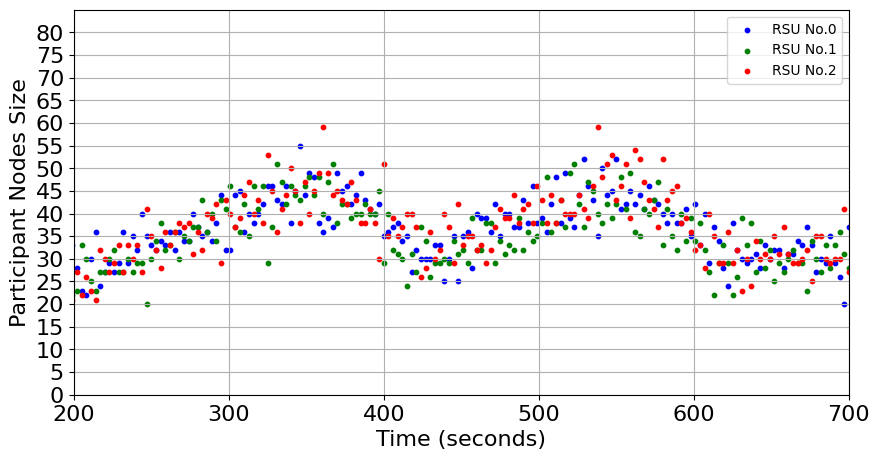

In [8]:
import matplotlib.pyplot as plt
import json

def count_nodes_for_plot_in_multiple_scenario(proposer_id, log_folder_path):

    extracted_events_file_path = log_folder_path + str(proposer_id) + "/immu_decided_participant_node_" + str(proposer_id) + ".json"

    # extracted_events.json jsonデータを読み込む
    with open(extracted_events_file_path, 'r') as f:
        data = json.load(f)


    # グラフにプロットするデータを抽出
    time_series = []
    status_counts = []

    for time_key, participant_node_list in data.items():
        # print(participant_node_list)
        start_time = float(time_key)
        status_count = len(participant_node_list)
        time_series.append(start_time)
        status_counts.append(status_count)

    
    return time_series, status_counts

max_speed = 80
min_speed = 20
proposer_list = [0,1,2]
validator_num = 250
log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/250vehicle/"


# proposer_id 0
time_series, status_counts = count_nodes_for_plot_in_multiple_scenario(proposer_list[0], log_folder_path)

# proposer_id 1
time_series2, status_counts2 = count_nodes_for_plot_in_multiple_scenario(proposer_list[1], log_folder_path)

# proposer_id 2
time_series3, status_counts3 = count_nodes_for_plot_in_multiple_scenario(proposer_list[2], log_folder_path)

#time_series, status_countsたちを10個おきにする
time_series = time_series[::300]
status_counts = status_counts[::300]
time_series2 = time_series2[::300]
status_counts2 = status_counts2[::300]
time_series3 = time_series3[::300]
status_counts3 = status_counts3[::300]

print(status_counts)

# 3つwo1つのgraphにまとめる
plt.figure(figsize=(10, 5))
plt.scatter(time_series, status_counts, c='blue', marker='o', s=10, label='RSU No.0')
plt.scatter(time_series2, status_counts2, c='green', marker='o', s=10, label='RSU No.1')
plt.scatter(time_series3, status_counts3, c='red', marker='o', s=10, label='RSU No.2')
# plt.scatter(time_series, status_counts, c='blue', marker='o', s=10)
# plt.scatter(time_series2, status_counts2, c='green', marker='o', s=10)
# plt.scatter(time_series3, status_counts3, c='red', marker='o', s=10)
plt.xlabel('Time (seconds)', fontsize=16)
plt.ylabel('Participant Nodes Size', fontsize=16)

# plt.ylim(0, None)
# plt.xlim(0, 800)
plt.ylim(0, 85)
plt.xlim(200, 700)

plt.xticks(fontsize=16)
plt.yticks(range(0, 85, 5),fontsize=16)

plt.grid(True)
plt.legend()
plt.show()

学習の評価の重み付けを変えたときの比較実験

a2c_vehicle_assignment_180_0.0_1.0
a2c_vehicle_assignment_180_0.2_0.8
a2c_vehicle_assignment_180_0.4_0.6
a2c_vehicle_assignment_180_0.6_0.4
a2c_vehicle_assignment_180_0.8_0.2
a2c_vehicle_assignment_180_1.0_0.0


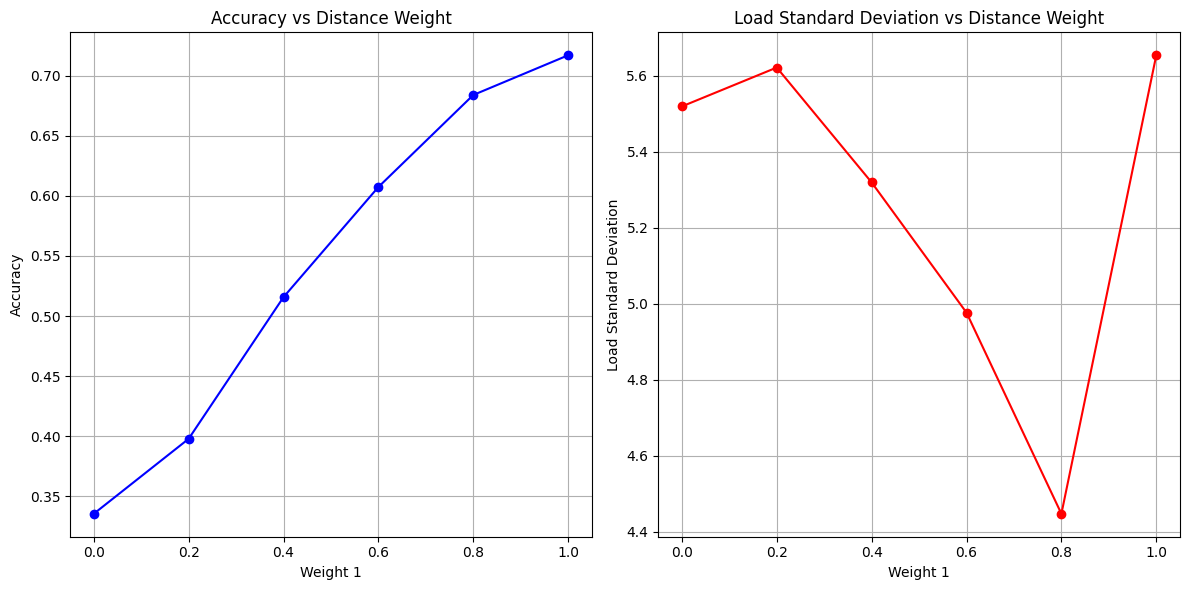

In [23]:
from stable_baselines3 import A2C
from statistics import mean

def caluculate_single_spec_rl(env, model):

    # 環境の初期化
    obs = env.reset()

    # 学習したモデルを用いてアクションを取得
    assignments = model.predict(obs)[0]

    # RSUの位置
    rsu_positions = np.array([
        [398.4, 0],              # 第1のRSUの位置
        [898.4, 0],              # 第2のRSUの位置
        [1398.4, 0]              # 第3のRSUの位置
    ])

    # 正解率と標準偏差の計算
    correct_assignments = 0
    for idx, action in enumerate(assignments):
        vehicle_position = env.vehicle_positions[idx]
        distances = np.array([np.linalg.norm(vehicle_position - rsu) for rsu in rsu_positions])
        closest_rsu = np.argmin(distances)
        if action == closest_rsu:
            correct_assignments += 1

    accuracy = correct_assignments / env.max_vehicles

    # RSUごとの負荷を計算
    rsu_loads = np.bincount(assignments, minlength=env.num_rsus)
    load_std_dev = np.std(rsu_loads)

    return accuracy, load_std_dev

def caluculate_multi_spec_rl(env, model, num_evaluations):
    accuracy_list = []
    load_std_dev_list = []

    for i in range(num_evaluations):
        accuracy_item, load_std_dev_item = caluculate_single_spec_rl(env, model)
        accuracy_list.append(accuracy_item)
        load_std_dev_list.append(load_std_dev_item)
    
    accuracy_average = mean(accuracy_list)
    load_std_dev_average = mean(load_std_dev_list)

    return accuracy_average, load_std_dev_average

# 環境の作成
env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=180)

# weight_list を用いてモデルをロードし、評価する
weight_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
num_evaluations = 500
accuracy_list = []
load_std_dev_list = []
for weight in weight_list:
    weight_1 = weight
    weight_2 = 1.0 - weight
    model_path = f"a2c_vehicle_assignment_180_{weight_1:.1f}_{weight_2:.1f}"
    print(model_path)
    model = A2C.load(model_path)
    accuracy_item, load_std_dev_item = caluculate_multi_spec_rl(env, model, num_evaluations)
    accuracy_list.append(accuracy_item)
    load_std_dev_list.append(load_std_dev_item)

# 精度と負荷標準偏差のプロット
plt.figure(figsize=(12, 6))

# 精度のプロット
plt.subplot(1, 2, 1)
plt.plot(weight_list, accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel('Weight 1')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Distance Weight')
plt.grid(True)

# 負荷標準偏差のプロット
plt.subplot(1, 2, 2)
plt.plot(weight_list, load_std_dev_list, marker='o', linestyle='-', color='r')
plt.xlabel('Weight 1')
plt.ylabel('Load Standard Deviation')
plt.title('Load Standard Deviation vs Distance Weight')
plt.grid(True)

plt.tight_layout()
plt.show()

